# Shock tube test

Procedure:
1) Input is v,p,e,rho 
2) Find ideal constants for diffusion
3) move forward in time with given constant
4) asses how good the timestep was, i.e loss func
    - Compare to analytical solution
    - Find oscillations due to noise with fft
    - compare to roe/lw scheme
5) Plot error etc
6) Compare computing time and error to better solvers such as Roe/LW
7) How many hidden layers? What activation function?

Reduce dimensionality of inputs? what are the most important characteristics?

In [2]:
import numpy as np
import nm_lib as nm
from lossfunc_CFD import *
from sklearn.model_selection import train_test_split

from ffnn import FFNN

nump = 256
cfl_cut = 0.1
Nt = 2000
dt = 0.0002
gamma = 5/3
t = np.linspace(0,Nt*dt,Nt+1)
print(t)

xx,u,rho,Pg = nm.init_sod_test(nump,1.0,0.125,1.0/gamma,0.125/gamma)
values = nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1])
X = values_to_X(values)
X,y = XY_from_X(X)

X_train, X_test, t_train, t_test = train_test_split(X, y)

[0.000e+00 2.000e-04 4.000e-04 ... 3.996e-01 3.998e-01 4.000e-01]
(2001, 257)


In [4]:
input_nodes = X_train.shape[1]
output_nodes = 3

linear_regression = FFNN((input_nodes, 256,9,output_nodes), seed=2023)
linear_regression.set_CFD_params(xx,dt,gamma)

In [3]:
from schedulers import *
import warnings
warnings.filterwarnings('ignore')

linear_regression.reset_weights() # reset weights such that previous runs or reruns don't affect the weights

scheduler = Momentum(eta=1e-2,momentum=0.1)
scores = linear_regression.fit(X_train, t_train, scheduler, epochs=100)


Momentum: Eta=0.01, Lambda=0
  [=======================================>] 100.0% 

In [4]:
const = linear_regression.predict(X_test)
print(const)

[[0.41592873 2.61556941 0.63236797]
 [0.41714602 2.61391212 0.63332175]
 [0.25732385 3.14460731 0.66261725]
 ...
 [0.43624975 2.56511555 0.63494726]
 [0.11603093 2.37789706 0.90591868]
 [0.03515923 2.67754481 0.72913185]]


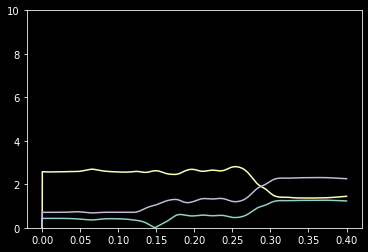

In [3]:
from matplotlib import style
import matplotlib.pyplot as plt
style.use('dark_background')
from lossfunc_CFD import *

Nt = 2000
t = np.linspace(0,Nt*dt,Nt+1)
values = nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1])
ut,rhot,Pt,et = values[1:]
xx,t,values,const = evolve_CFD_predict(xx,rhot[0],ut[0],et[0],Pt[0],linear_regression.predict,t,dt,gamma)

plt.plot(t,const[:,0])
plt.plot(t,const[:,1])
plt.plot(t,const[:,2])
plt.ylim(0,10)
values = [values]
values.append(nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1]))
names,uts,rhots,Pts,ets = nm.unpack_CFD_values(values)

#print(uts[0][1])
nm.animMultMHDparams(names,ets,uts,rhots,Pts,t,xx,n_frames=30)

# Model lookahead

The numerical noise caused by the numerical scheme is accumulated over time, and will not be apparent after just one timestep. As such, it is helpful to give the model an idea of what comes ahead and not just train it with the next timestep as the target, but as n timesteps as the target. However, this causes the model to have to iteratively move forward in time n times, which causes significantly slower training.

To combat this, the solver used by the network is rewritten with Numba compilation in mind, and has sacrificed some things in favor of speed like well calculated boundary conditions. Beware of this when the shock hits the edge of the simulation.

In [63]:
import cProfile
from schedulers import *
#import warnings


import numpy as np
import nm_lib as nm
from lossfunc_CFD import *
from sklearn.model_selection import train_test_split
from costfunc import *

from ffnn import FFNN
#warnings.filterwarnings('ignore')

nump = 256
cfl_cut = 0.1
Nt = 1500
dt = 0.0002
gamma = 5/3
t = np.linspace(0,Nt*dt,Nt+1)
print(t)

model_lookahead = 25

xx,u,rho,Pg = nm.init_sod_test(nump,1.0,0.125,1.0/gamma,0.125/gamma)
values = nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1])
X = values_to_X(values)
X,y = XY_from_X(X, Nt = model_lookahead)

X_train, X_test, t_train, t_test = train_test_split(X, y)
input_nodes = X_train.shape[1]
output_nodes = 3

linear_regression = FFNN((input_nodes,int(input_nodes/4),int(input_nodes/12),output_nodes*10,output_nodes*3,output_nodes), cost_func=CostOLS, seed=2023)
linear_regression.set_CFD_params(xx,dt,gamma, Nt=model_lookahead)

#linear_regression.reset_weights() # reset weights such that previous runs or reruns don't affect the weights

#scheduler = Momentum(eta=10e-2,momentum=1e-2)
scheduler = Constant(eta=1e-2)
#scores = linear_regression.fit(X_train, t_train, scheduler, epochs=100)
#cProfile.run("linear_regression.fit(X_train, t_train, scheduler, epochs=100)")
scores = linear_regression.fit(X_train, t_train, scheduler, epochs=50, lam = 1e-1)


[0.000e+00 2.000e-04 4.000e-04 ... 2.996e-01 2.998e-01 3.000e-01]
(1501, 257)
Constant: Eta=0.01, Lambda=0.1
  [=======================================>] 100.0% | train_error: 0.437 

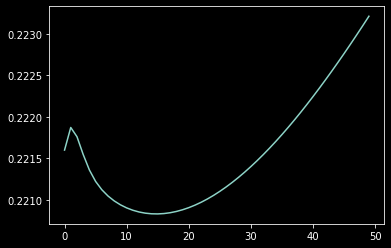

In [62]:
import matplotlib.pyplot as plt
#print(scores)
plt.plot(scores["train_errors"])

In [56]:
from matplotlib import style
import matplotlib.pyplot as plt
style.use('dark_background')
#from lossfunc_CFD import *
from hydrosolverfast import evolve_CFD_fast
import numpy as np
import nm_lib as nm

gamma = 5/3
t = np.linspace(0,Nt*dt,Nt+1)
xx,u,rho,Pg = nm.init_sod_test(nump,1.0,0.125,1.0/gamma,0.125/gamma)
values = nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1])
ut,rhot,Pt,et = values[1:]
xx,t,values,_ = evolve_CFD_fast(xx,rhot[0],ut[0],et[0],Pt[0],t,dt,gamma)
values = [values]
xx,t,values1,const = evolve_CFD_predict(xx,rhot[0],ut[0],et[0],Pt[0],linear_regression.predict,t,dt,gamma)
values.append(values1)

fig,ax = plt.subplots(3,1)
labels = ["cq","cL","cD"]
for i in range(len(ax)):
    ax[i].plot(t[1:],const[1:,i], label = labels[i])
    ax[i].legend()
#plt.ylim(0,10)


RuntimeWarning: overflow encountered in exp

In [49]:
values.append(nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1]))
names,uts,rhots,Pts,ets = nm.unpack_CFD_values(values)

#print(uts[0][1])
nm.animMultMHDparams(names,ets,uts,rhots,Pts,t,xx,n_frames=30)

# The numba solver

Below is the numba solver, note that it is fast but breaks at the boundaries. 

In [2]:
from matplotlib import style
import matplotlib.pyplot as plt
#style.use('dark_background')
#from lossfunc_CFD import *
from hydrosolverfast import evolve_CFD_fast
import numpy as np
import nm_lib as nm

Nt = 1500
nump = 256
dt = 0.0002
gamma = 5/3
t = np.linspace(0,Nt*dt,Nt+1)
xx,u,rho,Pg = nm.init_sod_test(nump,1.0,0.125,1.0/gamma,0.125/gamma)
values = nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1])
ut,rhot,Pt,et = values[1:]
xx,t,values,_ = evolve_CFD_fast(xx,rhot[0],ut[0],et[0],Pt[0],t,dt,gamma)
values = [values]

values.append(nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1]))
names,uts,rhots,Pts,ets = nm.unpack_CFD_values(values)

#print(uts[0][1])
nm.animMultMHDparams(names,ets,uts,rhots,Pts,t,xx,n_frames=12, figsize=(9,4))


Animating CFD params 



# Iterative feedback fitting 

In order to reduce the noise of our solver, we need to fit our model to noisy data. However, it can't just be any random noisy, it has to be the type of noise we want to target: Oscillation artifacts from the numerical scheme.

One way of doing so is to run the model once on analyitical X and targets, where the inputs and outputs are "pure" i.e no numerical noise. As such the model won't know about the noise it creates in this case and as such have no reason to adapt to it and will create noisy data. 

Next, we take said noisy data as our X (initial condition) and train the model on data filled with its own numerical noise. As such, the model becomes good at taming very noisy data.

Doing this iteratively is the same as running the numerical scheme on itself many times, and as such it will get more and more diffusive as the numerical scheme used is in essence a spatial average. 

In [1]:
import numpy as np
import nm_lib as nm
from lossfunc_CFD import *
from sklearn.model_selection import train_test_split
from costfunc import *
from fitting_routines import iterate_fit_simple, setup_evolve_predict
from schedulers import *
import matplotlib.pyplot as plt

from ffnn import FFNN
#warnings.filterwarnings('ignore')

nump = 256
cfl_cut = 0.1
Nt = 1200
dt = 0.0002
gamma = 5/3
t = np.linspace(0,Nt*dt,Nt+1)
print(t)

model_lookahead = 20

xx,u,rho,Pg = nm.init_sod_test(nump,1.0,0.125,1.0/gamma,0.125/gamma)
values = nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1])
ut,rhot,Pt,et = values[1:]
X = values_to_X(values)
X,y = XY_from_X(X, Nt = model_lookahead)

X_train, X_test, t_train, t_test = train_test_split(X, y)
input_nodes = X_train.shape[1]
output_nodes = 3

linear_regression = FFNN((input_nodes,int(input_nodes/4),int(input_nodes/12),output_nodes*10,output_nodes*3,output_nodes), cost_func=CostOLS, seed=2023)
linear_regression.set_CFD_params(xx,dt,gamma, Nt=model_lookahead)

#linear_regression.reset_weights() # reset weights such that previous runs or reruns don't affect the weights

#scheduler = Momentum(eta=10e-2,momentum=1e-2)
scheduler = Constant(eta=1e-2)
#scores = linear_regression.fit(X_train, t_train, scheduler, epochs=100)
#cProfile.run("linear_regression.fit(X_train, t_train, scheduler, epochs=100)")
evolve_predict = setup_evolve_predict(xx,rhot[0],ut[0],et[0],Pt[0],t,dt,gamma)
iter_fit = 1
model, scores, error = iterate_fit_simple(linear_regression,scheduler,evolve_predict,iter_fit,X,y, model_lookahead)


#Plotting

for i,err in enumerate(error):
    plt.plot(err, label=f"it = {i}")
plt.legend()

Nt = 1200
t = np.linspace(0,Nt*dt,Nt+1)
values = []
xx,u,rho,Pg = nm.init_sod_test(nump,1.0,0.125,1.0/gamma,0.125/gamma)
values.append( nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1]))

xx,t,values1,const = evolve_CFD_predict(xx,rhot[0],ut[0],et[0],Pt[0],linear_regression.predict,t,dt,gamma)
values.append(values1)

fig,ax = plt.subplots(3,1)
labels = ["cq","cL","cD"]
for i in range(len(ax)):
    ax[i].plot(t[1:],const[1:,i], label = labels[i])
    ax[i].legend()
#plt.ylim(0,10)
#values.append(nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1]))
names,uts,rhots,Pts,ets = nm.unpack_CFD_values(values)

#print(uts[0][1])
nm.animMultMHDparams(names,ets,uts,rhots,Pts,t,xx,n_frames=30)


/Users/gauteholen/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[0.000e+00 2.000e-04 4.000e-04 ... 2.396e-01 2.398e-01 2.400e-01]


ValueError: too many values to unpack (expected 2)

# Combine a stack of different data

To further improve the network's ability to handle the targeted noise, a combination of sources are added:
1) Iterative feedback (typical noise oscillations produced by the network solver, more extreme noise)
2) Constant diffusive constants ("Typical" values for the network without extremes, prevents overfitting)
3) Analytical solutions (Prevent overfitiing for noise and best at preserving the shock fronts overall shape)

# Linear slicing



In [1]:
import numpy as np
import nm_lib as nm
from lossfunc_CFD import *
from sklearn.model_selection import train_test_split
from costfunc import *
from fitting_routines import iterate_fit_stackX, setup_evolve_predict, setup_evolve_CFD_fast
from schedulers import *
import matplotlib.pyplot as plt

from ffnn import FFNN
#warnings.filterwarnings('ignore')

nump = 256
cfl_cut = 0.1
Nt = 1200
dt = 0.0002
gamma = 5/3
t = np.linspace(0,Nt*dt,Nt+1)
print(t)

model_lookahead = 20

xx,u,rho,Pg = nm.init_sod_test(nump,1.0,0.125,1.0/gamma,0.125/gamma)
values = nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1])
ut,rhot,Pt,et = values[1:]
X = values_to_X(values)
X,y = XY_from_X(X, Nt = model_lookahead)

X_train, X_test, t_train, t_test = train_test_split(X, y)
input_nodes = X_train.shape[1]
output_nodes = 3

linear_regression = FFNN((input_nodes,int(input_nodes/4),int(input_nodes/12),output_nodes*10,output_nodes*3,output_nodes), cost_func=CostOLS, seed=2023)
linear_regression.set_CFD_params(xx,dt,gamma, Nt=model_lookahead)

#linear_regression.reset_weights() # reset weights such that previous runs or reruns don't affect the weights

#scheduler = Momentum(eta=10e-2,momentum=1e-2)
scheduler = Constant(eta=1e-2)
#scores = linear_regression.fit(X_train, t_train, scheduler, epochs=100)
#cProfile.run("linear_regression.fit(X_train, t_train, scheduler, epochs=100)")
evolve_predict = setup_evolve_predict(xx,rhot[0],ut[0],et[0],Pt[0],t,dt,gamma)
evolve_fast = setup_evolve_CFD_fast(xx,rhot[0],ut[0],et[0],Pt[0],t,dt,gamma)
iter_fit = 1
model, scores, error, err_labels = iterate_fit_stackX(linear_regression,scheduler,evolve_predict,evolve_fast,iter_fit,X,y, model_lookahead, slicing = "linear")


#Plotting

for i,err in enumerate(error):
    plt.plot(err, label=err_labels[i])
plt.legend()

Nt = 1200
t = np.linspace(0,Nt*dt,Nt+1)
values = []
xx,u,rho,Pg = nm.init_sod_test(nump,1.0,0.125,1.0/gamma,0.125/gamma)
values.append( nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1]))

xx,t,values1,const = evolve_CFD_predict(xx,rhot[0],ut[0],et[0],Pt[0],linear_regression.predict,t,dt,gamma)
values.append(values1)

fig,ax = plt.subplots(3,1)
labels = ["cq","cL","cD"]
for i in range(len(ax)):
    ax[i].plot(t[1:],const[1:,i], label = labels[i])
    ax[i].legend()
#plt.ylim(0,10)
#values.append(nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1]))
names,uts,rhots,Pts,ets = nm.unpack_CFD_values(values)

#print(uts[0][1])
nm.animMultMHDparams(names,ets,uts,rhots,Pts,t,xx,n_frames=30)

/Users/gauteholen/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[0.000e+00 2.000e-04 4.000e-04 ... 2.396e-01 2.398e-01 2.400e-01]


ValueError: too many values to unpack (expected 2)

# Log slicing 

In [1]:
import numpy as np
import nm_lib as nm
from lossfunc_CFD import *
from sklearn.model_selection import train_test_split
from costfunc import *
from fitting_routines import iterate_fit_stackX, setup_evolve_predict, setup_evolve_CFD_fast
from schedulers import *
import matplotlib.pyplot as plt

from ffnn import FFNN
#warnings.filterwarnings('ignore')

nump = 512
cfl_cut = 0.1
Nt = 3000 #1500
dt = 0.0001#0.0002
gamma = 5/3
t = np.linspace(0,Nt*dt,Nt+1)

model_lookahead = 20

xx,u,rho,Pg = nm.init_sod_test(nump,1.0,0.125,1.0/gamma,0.125/gamma)
values = nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1])
ut,rhot,Pt,et = values[1:]
X = values_to_X(values)
X,y, y_onestep = XY_from_X(X, Nt = model_lookahead)

X_train, X_test, t_train, t_test = train_test_split(X, y)
input_nodes = X_train.shape[1]
output_nodes = 3
epochs = 60

linear_regression = FFNN((input_nodes,int(input_nodes/4),int(input_nodes/12),output_nodes*10,output_nodes*3,output_nodes), cost_func=CostOLS, seed=2023)
linear_regression.set_CFD_params(xx,dt,gamma, Nt=model_lookahead)
linear_regression.setup_evolve_predict(values,t)




#linear_regression.reset_weights() # reset weights such that previous runs or reruns don't affect the weights

#scheduler = Adam(eta=1e-2,rho=1e-2, rho2 = 1e-2)
#scheduler = Constant(eta=1e-2)
scheduler = Momentum(eta=3e-2, momentum=0.5)
#scheduler = Momentum(eta=1e-2, momentum=0.5)
#scores = linear_regression.fit(X_train, t_train, scheduler, epochs=100)
#cProfile.run("linear_regression.fit(X_train, t_train, scheduler, epochs=100)")
evolve_predict = setup_evolve_predict(xx,rhot[0],ut[0],et[0],Pt[0],t,dt,gamma)
evolve_fast = setup_evolve_CFD_fast(xx,rhot[0],ut[0],et[0],Pt[0],t,dt,gamma)
iter_fit = 1
model, scores, error, err_labels, fit_values = iterate_fit_stackX(linear_regression,scheduler,evolve_predict,evolve_fast,iter_fit,X,y,y_onestep, model_lookahead, slicing = "linear", epochs=epochs)




/Users/gauteholen/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Log slice

 Coonstant cq, cL, cD
Mean error =  0.0014275411231308027

 First fit
Momentum: Eta=0.03, Lambda=0
  [=======================================>] 100.0% | train_error: 0.00305 Mean error =  0.0033260139182816665

 First feedback fit
Momentum: Eta=0.03, Lambda=0
  [=======================================>] 100.0% | train_error: 0.00286 Mean error =  0.003089329821759148

Running first stack fit
Momentum: Eta=0.03, Lambda=0
  [=======================================>] 100.0% | train_error: 0.00295 Mean error =  0.003210925026576412

Running stack fit feedback
Momentum: Eta=0.03, Lambda=0
  [=======================================>] 100.0% | train_error: 0.00245  Mean error =  0.0026625431199762176


# Iterate Feedback

In [1]:
import numpy as np
import nm_lib as nm
from lossfunc_CFD import *
from sklearn.model_selection import train_test_split
from costfunc import *
from fitting_routines import iterate_fit_simple, setup_evolve_predict, setup_evolve_CFD_fast
from schedulers import *
import matplotlib.pyplot as plt

from ffnn import FFNN
#warnings.filterwarnings('ignore')

nump = 256
cfl_cut = 0.1
Nt = 1500 #1500
dt = 0.0002#0.0002
gamma = 5/3
t = np.linspace(0,Nt*dt,Nt+1)

model_lookahead = 1

xx,u,rho,Pg = nm.init_sod_test(nump,1.0,0.125,1.0/gamma,0.125/gamma)
values = nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1])
ut,rhot,Pt,et = values[1:]
X = values_to_X(values)
X,y, y_onestep = XY_from_X(X, Nt = model_lookahead)

X_train, X_test, t_train, t_test = train_test_split(X, y)
input_nodes = X_train.shape[1]
output_nodes = 3
epochs = 10

linear_regression = FFNN((input_nodes,
                            int(input_nodes/4),
                            int(input_nodes/12),
                            output_nodes*10,
                            output_nodes*3,
                            output_nodes), cost_func=CostOLS, seed=2023)
linear_regression.set_CFD_params(xx,dt,gamma, Nt=model_lookahead)
linear_regression.setup_evolve_predict(values,t)




#linear_regression.reset_weights() # reset weights such that previous runs or reruns don't affect the weights

#scheduler = Adam(eta=1e-2,rho=1e-2, rho2 = 1e-2)
#scheduler = Constant(eta=1e-2)
scheduler = Momentum(eta=1e-2, momentum=0.5)
#scheduler = Momentum(eta=1e-2, momentum=0.5)
#scores = linear_regression.fit(X_train, t_train, scheduler, epochs=100)
#cProfile.run("linear_regression.fit(X_train, t_train, scheduler, epochs=100)")
evolve_predict = setup_evolve_predict(xx,rhot[0],ut[0],et[0],Pt[0],t,dt,gamma)
evolve_fast = setup_evolve_CFD_fast(xx,rhot[0],ut[0],et[0],Pt[0],t,dt,gamma)
iter_fit = 8
model, scores, error, err_labels, fit_values, consts = iterate_fit_simple(linear_regression,scheduler,evolve_predict,iter_fit,X,y, model_lookahead, slicing = "None", epochs=epochs)




/Users/gauteholen/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


no slice
Momentum: Eta=0.1, Lambda=1e-05
  [=======================================>] 100.0% | train_error: 0.00177 
Mean error =  0.0016072544067109132
Momentum: Eta=0.05, Lambda=1e-05
  [=======================================>] 100.0% | train_error: 0.00158 
Mean error =  0.0015617279876095095
Momentum: Eta=0.03333333333333333, Lambda=1e-05
  [=======================================>] 100.0% | train_error: 0.00165 
Mean error =  0.0015758313667249113
Momentum: Eta=0.025, Lambda=1e-05
  [=======================================>] 100.0% | train_error: 0.00170 
Mean error =  0.0015828965581085044
Momentum: Eta=0.02, Lambda=1e-05
  [=======================================>] 100.0% | train_error: 0.00161 
Mean error =  0.001565160214235366
Momentum: Eta=0.016666666666666666, Lambda=1e-05
  [=======================================>] 100.0% | train_error: 0.00156 
Mean error =  0.0015571938596992147
Momentum: Eta=0.014285714285714287, Lambda=1e-05
  [=======================================

# Tanh

In [7]:
import numpy as np
import nm_lib as nm
from lossfunc_CFD import *
from sklearn.model_selection import train_test_split
from costfunc import *
from fitting_routines import iterate_fit_simple, setup_evolve_predict, setup_evolve_CFD_fast
from schedulers import *
import matplotlib.pyplot as plt

from ffnn import FFNN, tanh
#warnings.filterwarnings('ignore')

nump = 256
cfl_cut = 0.1
Nt = 1500 #1500
dt = 0.0002#0.0002
gamma = 5/3
t = np.linspace(0,Nt*dt,Nt+1)

model_lookahead = 1

xx,u,rho,Pg = nm.init_sod_test(nump,1.0,0.125,1.0/gamma,0.125/gamma)
values = nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1])
ut,rhot,Pt,et = values[1:]
X = values_to_X(values)
X,y, y_onestep = XY_from_X(X, Nt = model_lookahead)

X_train, X_test, t_train, t_test = train_test_split(X, y)
input_nodes = X_train.shape[1]
output_nodes = 3
epochs = 12

linear_regression = FFNN((input_nodes,

                            int(input_nodes/4),
                            int(input_nodes/12),
 
                            output_nodes*10,

                            output_nodes*3,
                            output_nodes), cost_func=CostOLS, hidden_func = tanh,seed=2023)
linear_regression.set_CFD_params(xx,dt,gamma, Nt=model_lookahead)
linear_regression.setup_evolve_predict(values,t)




#linear_regression.reset_weights() # reset weights such that previous runs or reruns don't affect the weights

#scheduler = Adam(eta=1e-2,rho=1e-2, rho2 = 1e-2)
#scheduler = Constant(eta=1e-2)
scheduler = Momentum(eta=1e-2, momentum=0.5)
#scheduler = Momentum(eta=1e-2, momentum=0.5)
#scores = linear_regression.fit(X_train, t_train, scheduler, epochs=100)
#cProfile.run("linear_regression.fit(X_train, t_train, scheduler, epochs=100)")
evolve_predict = setup_evolve_predict(xx,rhot[0],ut[0],et[0],Pt[0],t,dt,gamma)
evolve_fast = setup_evolve_CFD_fast(xx,rhot[0],ut[0],et[0],Pt[0],t,dt,gamma)
iter_fit = 4
tanh_data = iterate_fit_simple(linear_regression,scheduler,evolve_predict,iter_fit,X,y, model_lookahead, eta = 3e-2, slicing = "None", epochs=epochs)

model, scores, error, err_labels, fit_values_tanh, consts = tanh_data


no slice
Momentum: Eta=0.03, Lambda=1e-05
  [=======================================>] 100.0% | train_error: 0.00162 
Mean error =  0.001610438734426209
Momentum: Eta=0.015, Lambda=1e-05
  [=======================================>] 100.0% | train_error: 0.00163 
Mean error =  0.0016659818820858906
Momentum: Eta=0.01, Lambda=1e-05
  [=======================================>] 100.0% | train_error: 0.00160 
Mean error =  0.0015936739290599877
Momentum: Eta=0.0075, Lambda=1e-05
  [=======================================>] 100.0% | train_error: 0.00152 
Mean error =  0.0014976017086243913


# Sigmoid

In [4]:
import numpy as np
import nm_lib as nm
from lossfunc_CFD import *
from sklearn.model_selection import train_test_split
from costfunc import *
from fitting_routines import iterate_fit_simple, setup_evolve_predict, setup_evolve_CFD_fast
from schedulers import *
import matplotlib.pyplot as plt

from ffnn import FFNN, sigmoid
#warnings.filterwarnings('ignore')

nump = 256
cfl_cut = 0.1
Nt = 1500 #1500
dt = 0.0002#0.0002
gamma = 5/3
t = np.linspace(0,Nt*dt,Nt+1)

model_lookahead = 1

xx,u,rho,Pg = nm.init_sod_test(nump,1.0,0.125,1.0/gamma,0.125/gamma)
values = nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1])
ut,rhot,Pt,et = values[1:]
X = values_to_X(values)
X,y, y_onestep = XY_from_X(X, Nt = model_lookahead)

X_train, X_test, t_train, t_test = train_test_split(X, y)
input_nodes = X_train.shape[1]
output_nodes = 3
epochs = 10

linear_regression = FFNN((input_nodes,

                            int(input_nodes/4),
                            int(input_nodes/12),
 
                            output_nodes*10,

                            output_nodes*3,
                            output_nodes), cost_func=CostOLS, hidden_func = sigmoid,seed=2023)
linear_regression.set_CFD_params(xx,dt,gamma, Nt=model_lookahead)
linear_regression.setup_evolve_predict(values,t)




#linear_regression.reset_weights() # reset weights such that previous runs or reruns don't affect the weights

#scheduler = Adam(eta=1e-2,rho=1e-2, rho2 = 1e-2)
#scheduler = Constant(eta=1e-2)
scheduler = Momentum(eta=1e-2, momentum=0.5)
#scheduler = Momentum(eta=1e-2, momentum=0.5)
#scores = linear_regression.fit(X_train, t_train, scheduler, epochs=100)
#cProfile.run("linear_regression.fit(X_train, t_train, scheduler, epochs=100)")
evolve_predict = setup_evolve_predict(xx,rhot[0],ut[0],et[0],Pt[0],t,dt,gamma)
evolve_fast = setup_evolve_CFD_fast(xx,rhot[0],ut[0],et[0],Pt[0],t,dt,gamma)
iter_fit = 4
sigmoid_data = iterate_fit_simple(linear_regression,scheduler,evolve_predict,iter_fit,X,y, model_lookahead, eta = 0.9e-1, slicing = "None", epochs=epochs)

#model, scores, error, err_labels, fit_values_tanh, consts = tanh_data


no slice
Momentum: Eta=0.09, Lambda=1e-05
  [=======================================>] 100.0% | train_error: 0.00177 
Mean error =  0.0016177935442584594
Momentum: Eta=0.045, Lambda=1e-05
  [=======================================>] 100.0% | train_error: 0.00156 
Mean error =  0.0015821698728868616
Momentum: Eta=0.03, Lambda=1e-05
  [=======================================>] 100.0% | train_error: 0.00157 
Mean error =  0.0015615636174421009
Momentum: Eta=0.0225, Lambda=1e-05
  [=======================================>] 100.0% | train_error: 0.00163 
Mean error =  0.0015540910957670662


# Effect of lookahead sigmoid?

In [16]:
import numpy as np
import nm_lib as nm
from lossfunc_CFD import *
from sklearn.model_selection import train_test_split
from costfunc import *
from fitting_routines import iterate_fit_simple, setup_evolve_predict, setup_evolve_CFD_fast
from schedulers import *
import matplotlib.pyplot as plt

from ffnn import FFNN, sigmoid
#warnings.filterwarnings('ignore')

nump = 256
cfl_cut = 0.1
Nt = 1500 #1500
dt = 0.0002#0.0002
gamma = 5/3
t = np.linspace(0,Nt*dt,Nt+1)

model_lookahead = 100

xx,u,rho,Pg = nm.init_sod_test(nump,1.0,0.125,1.0/gamma,0.125/gamma)
values = nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1])
ut,rhot,Pt,et = values[1:]
X = values_to_X(values)
X,y, y_onestep = XY_from_X(X, Nt = model_lookahead)

X_train, X_test, t_train, t_test = train_test_split(X, y)
input_nodes = X_train.shape[1]
output_nodes = 3
epochs = 20

linear_regression = FFNN((input_nodes,

                            int(input_nodes/4),
                            int(input_nodes/12),
 
                            output_nodes*10,

                            output_nodes*3,
                            output_nodes), cost_func=CostOLS, hidden_func = sigmoid,seed=2023)
linear_regression.set_CFD_params(xx,dt,gamma, Nt=model_lookahead)
linear_regression.setup_evolve_predict(values,t)




#linear_regression.reset_weights() # reset weights such that previous runs or reruns don't affect the weights

#scheduler = Adam(eta=1e-2,rho=1e-2, rho2 = 1e-2)
#scheduler = Constant(eta=1e-2)
scheduler = Momentum(eta=1e-2, momentum=0.5)
#scheduler = Momentum(eta=1e-2, momentum=0.5)
#scores = linear_regression.fit(X_train, t_train, scheduler, epochs=100)
#cProfile.run("linear_regression.fit(X_train, t_train, scheduler, epochs=100)")
evolve_predict = setup_evolve_predict(xx,rhot[0],ut[0],et[0],Pt[0],t,dt,gamma)
evolve_fast = setup_evolve_CFD_fast(xx,rhot[0],ut[0],et[0],Pt[0],t,dt,gamma)
iter_fit = 3
sigmoid_data_lookahead = iterate_fit_simple(linear_regression,scheduler,evolve_predict,iter_fit,X,y, model_lookahead, eta = 0.9e-1, slicing = "None", epochs=epochs)

#model, scores, error, err_labels, fit_values_tanh, consts = tanh_data


no slice
Momentum: Eta=0.09, Lambda=1e-05
  [=======================================>] 100.0% | train_error: 0.00177 
Mean error =  0.0016803991248817126
Momentum: Eta=0.045, Lambda=1e-05
  [=======================================>] 100.0% | train_error: 0.00164 
Mean error =  0.0015222407669109957
Momentum: Eta=0.03, Lambda=1e-05
  [=======================================>] 100.0% | train_error: 0.00164 
Mean error =  0.0015588563195535982


# Effect of lookahead tanh

In [34]:
import numpy as np
import nm_lib as nm
from lossfunc_CFD import *
from sklearn.model_selection import train_test_split
from costfunc import *
from fitting_routines import iterate_fit_simple, setup_evolve_predict, setup_evolve_CFD_fast
from schedulers import *
import matplotlib.pyplot as plt

from ffnn import FFNN, tanh
#warnings.filterwarnings('ignore')

nump = 256
cfl_cut = 0.1
Nt = 1500 #1500
dt = 0.0002#0.0002
gamma = 5/3
t = np.linspace(0,Nt*dt,Nt+1)

model_lookahead = 100

xx,u,rho,Pg = nm.init_sod_test(nump,1.0,0.125,1.0/gamma,0.125/gamma)
values = nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1])
ut,rhot,Pt,et = values[1:]
X = values_to_X(values)
X,y, y_onestep = XY_from_X(X, Nt = model_lookahead)

X_train, X_test, t_train, t_test = train_test_split(X, y)
input_nodes = X_train.shape[1]
output_nodes = 3
epochs = 30

linear_regression = FFNN((input_nodes,

                            int(input_nodes/4),
                            int(input_nodes/12),
 
                            output_nodes*10,

                            output_nodes*3,
                            output_nodes), cost_func=CostOLS, hidden_func = tanh,seed=2023)
linear_regression.set_CFD_params(xx,dt,gamma, Nt=model_lookahead)
linear_regression.setup_evolve_predict(values,t)




#linear_regression.reset_weights() # reset weights such that previous runs or reruns don't affect the weights

#scheduler = Adam(eta=1e-2,rho=1e-2, rho2 = 1e-2)
#scheduler = Constant(eta=1e-2)
scheduler = Momentum(eta=1e-2, momentum=0.5)
#scheduler = Momentum(eta=1e-2, momentum=0.5)
#scores = linear_regression.fit(X_train, t_train, scheduler, epochs=100)
#cProfile.run("linear_regression.fit(X_train, t_train, scheduler, epochs=100)")
evolve_predict = setup_evolve_predict(xx,rhot[0],ut[0],et[0],Pt[0],t,dt,gamma)
evolve_fast = setup_evolve_CFD_fast(xx,rhot[0],ut[0],et[0],Pt[0],t,dt,gamma)
iter_fit = 3
tanh_data_lookahead = iterate_fit_simple(linear_regression,scheduler,evolve_predict,iter_fit,X,y, model_lookahead, eta = 3e-2, slicing = "None", epochs=epochs)

#model, scores, error, err_labels, fit_values_tanh, consts = tanh_data


no slice
Momentum: Eta=0.03, Lambda=1e-05
  [=======================================>] 100.0% | train_error: 0.00173 
Mean error =  0.0016720908101105676
Momentum: Eta=0.015, Lambda=1e-05
  [=======================================>] 100.0% | train_error: 0.00162 
Mean error =  0.001636766660051151
Momentum: Eta=0.01, Lambda=1e-05
  [=======================================>] 100.0% | train_error: 0.00160 
Mean error =  0.0015128850088402784


cq = 0, cL = 0, cD = 0 0.005663762905808368
cq = 1, cL = 1, cD = 1 0.0017787584699331688
cq = 3, cL = 3, cD = 3 0.0019316109451337651
cq = 2, cL = 2, cD = 2 0.0016381679570570344
Predict tanh 0.0014982223772432959
Predict sigmoid 0.0015547716059531437
Adding species Lax-Wendroff of type h
Running with scheme LF
Adding species Roe of type h
Running with scheme ROE
Lax-Wendroff 0.0011886470116542448
Roe 0.0011557647966134535


Text(0, 0.5, 'OLS')

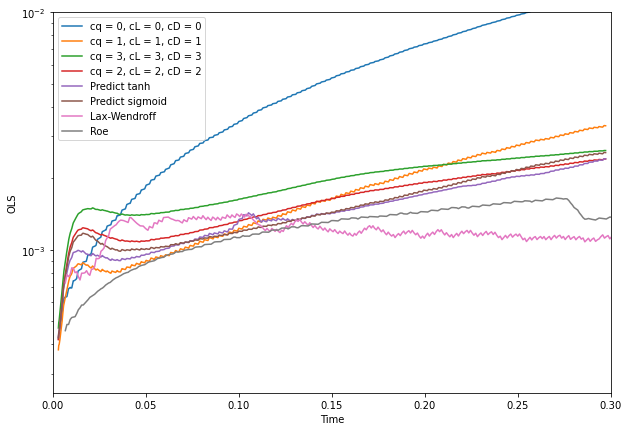

In [11]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


from copy import copy
t = np.linspace(0,Nt*dt,Nt+1)

# Compare everything
compare_values = []


model_tanh, scores, error, err_labels, fit_values_tanh, consts = tanh_data
model_sigmoid, scores, error, err_labels, fit_values_sigmoid, consts = sigmoid_data

#Constant diff const
evolve_fast = setup_evolve_CFD_fast(xx,rhot[0],ut[0],et[0],Pt[0],t,dt,gamma)
xx,t,values_c,const = evolve_fast(0,0,0)
values_c[0] = "cq = 0, cL = 0, cD = 0"
compare_values.append(copy(values_c))

xx,t,values_c,const = evolve_fast(1,1,1)
values_c[0] = "cq = 1, cL = 1, cD = 1"
compare_values.append(copy(values_c))

xx,t,values_c,const = evolve_fast(3,3,3)
values_c[0] = "cq = 3, cL = 3, cD = 3"
compare_values.append(copy(values_c))

xx,t,values_c,const = evolve_fast(2,2,2)
values_c[0] = "cq = 2, cL = 2, cD = 2"
compare_values.append(copy(values_c))

fit_values_t = fit_values_tanh[-1]
fit_values_t[0] = "Predict tanh"
compare_values.append(fit_values_t)

fit_values_sig = fit_values_sigmoid[-1]
fit_values_sig[0] = "Predict sigmoid"
compare_values.append(fit_values_sig)
compare_values.append( nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1]))




#names[0:5] = "Const","Bad fit","First Feedback", "First Stack", "Second Feedback"
#names = err_labels

w = 30
whalf = int(w/2)

# Const dt
plt.figure(figsize=(10,7))
names,uts,rhots,Pts,ets = nm.unpack_CFD_values(compare_values)
for name,ut,rhot,Pt,et in zip(names[:-1],uts[:-1],rhots[:-1],Pts[:-1],ets[:-1]):
    errt = np.zeros(ut.shape[0]-1)
    errt = 0
    errt += np.mean((ut[:]-uts[-1][:])**2, axis=1)
    errt += np.mean((rhot[:]-rhots[-1][:])**2, axis=1)
    errt += np.mean((Pt[:]-Pts[-1][:])**2, axis=1)
    errt += np.mean((et[:]-ets[-1][:])**2, axis=1)
    errt *= 0.25
    #errt[1:] *= 0.25/t[1:-1]
    print(name,np.mean(errt))
    errt = moving_average(errt,w)
    plt.plot(t[whalf:-whalf+1],errt, label = name)
plt.legend()


cfl_cut = 0.5
solver = nm.Multispecies(xx,nm.deriv_4tho,bnd_limits = [2,2],bnd_type="edge")
solver.add_species("Lax-Wendroff",u,rho,Pg,gamma)
tlw,xxlw,valuesLW = solver.run(Nt,cfl_cut=cfl_cut,coupled=False,conservative = True, flux_algo = "LF")
valuesAnaLW = nm.ana_sod_shock(xxlw,gamma,tlw, Pg[0],Pg[-1],rho[0],rho[-1], conserv=True)

solver = nm.Multispecies(xx,nm.deriv_4tho,bnd_limits = [2,2],bnd_type="edge")
solver.add_species("Roe",u,rho,Pg,gamma)
tr,xxr,valuesRoe = solver.run(Nt,cfl_cut=cfl_cut,coupled=False,conservative = True, flux_algo="ROE")

valuesAnaRoe = nm.ana_sod_shock(xxr,gamma,tr, Pg[0],Pg[-1],rho[0],rho[-1], conserv=True)

values_adv_solv = [valuesLW[0],valuesAnaLW]

#Lax
w = 10
whalf = int(w/2)
names,uts,rhots,Pts,ets = nm.unpack_CFD_values(values_adv_solv)
for name,ut,rhot,Pt,et in zip(names[:-1],uts[:-1],rhots[:-1],Pts[:-1],ets[:-1]):
    errt = np.zeros(ut.shape[0]-1)
    errt = 0
    errt += np.mean((ut[:]-uts[-1][:])**2, axis=1)
    errt += np.mean((rhot[:]-rhots[-1][:])**2, axis=1)
    errt += np.mean((Pt[:]-Pts[-1][:])**2, axis=1)
    errt += np.mean((et[:]-ets[-1][:])**2, axis=1)
    errt *= 0.25
    #errt[1:] *= 0.25/t[1:-1]
    #print(errt)
    tmean = np.where(tlw < t[-1])[0]
    print(name,np.mean(errt[1:tmean.shape[0]]))
    errt = moving_average(errt[1:],w)
    tlwp = tlw[1:]
    plt.plot(tlwp[whalf:-whalf+1],errt, label = name)
plt.legend()



values_adv_solv = [valuesRoe[0],valuesAnaRoe]

#Roe
w = 10
whalf = int(w/2)
names,uts,rhots,Pts,ets = nm.unpack_CFD_values(values_adv_solv)
for name,ut,rhot,Pt,et in zip(names[:-1],uts[:-1],rhots[:-1],Pts[:-1],ets[:-1]):
    errt = np.zeros(ut.shape[0]-1)
    errt = 0
    errt += np.mean((ut[:]-uts[-1][:])**2, axis=1)
    errt += np.mean((rhot[:]-rhots[-1][:])**2, axis=1)
    errt += np.mean((Pt[:]-Pts[-1][:])**2, axis=1)
    errt += np.mean((et[:]-ets[-1][:])**2, axis=1)
    errt *= 0.25
    #errt[1:] *= 0.25/t[1:-1]

    tmean = np.where(tr < t[-1])[0]
    print(name,np.mean(errt[1:tmean.shape[0]]))
    errt = moving_average(errt[1:],w)
    trp = tlw[1:]
    plt.plot(trp[whalf:-whalf+1],errt, label = name)
plt.legend()

plt.yscale("log")
plt.xlim(0,t[-1])
plt.ylim(0.25e-3,1e-2)
plt.xlabel("Time")
plt.ylabel("OLS")



#nm.animMultMHDparams(names,ets,uts,rhots,Pts,tlw,xxlw,n_frames=30)

Text(0.5, 0, 'epochs')

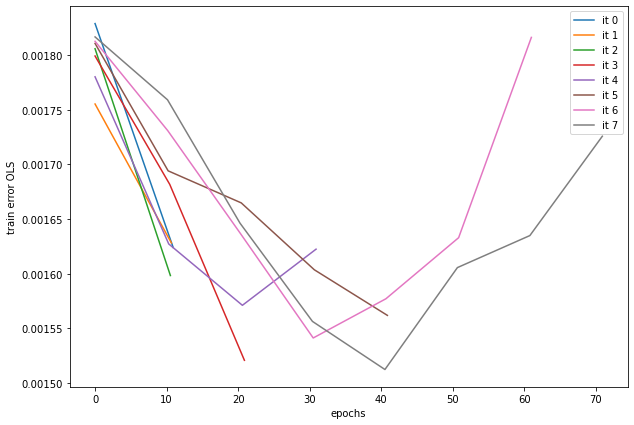

In [3]:
#Plotting
plt.figure(figsize=(10,7))
for i,score in enumerate(scores[:]):
    n = (len(score["train_errors"]))
    plt.plot(np.linspace(0,n,n)[0::10],score["train_errors"][0::10], label = f"it {i}")
plt.legend(loc=1)
plt.ylabel("train error OLS")
plt.xlabel("epochs")

In [29]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w






#Nt = 1500
t = np.linspace(0,Nt*dt,Nt+1)
values = []
xx,u,rho,Pg = nm.init_sod_test(nump,1.0,0.125,1.0/gamma,0.125/gamma)
values.append( nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1]))
"""
model_sigmoid, scores, error, err_labels, fit_values_sigmoid, consts = sigmoid_data
xx,t,values2,const_sig = evolve_CFD_predict(xx,rhot[0],ut[0],et[0],Pt[0],model_sigmoid.predict,t,dt,gamma)
values2[0] = "Predict Sigmoid"
values.append(values2)


model_tanh, scores, error, err_labels, fit_values_tanh, consts = tanh_data
xx,t,values1,const_tanh = evolve_CFD_predict(xx,rhot[0],ut[0],et[0],Pt[0],model_tanh.predict,t,dt,gamma)
values1[0] = "Predict tanh"
values.append(values1)



const_models = [const_tanh, const_sig]
model_names = ["tanh","sigmoid"]
fig,ax = plt.subplots(3,1, figsize = (10,7))
for j in [0,1]:
    const = const_models[j]
    label = model_names[j]
    for i in range(len(ax)):
        ax[i].plot(t[1:],const[1:,i], label = label)
        #ax[i].legend()
ax[-1].set_xlabel("Time")
ax[0].set_ylabel("$c_q$")
ax[1].set_ylabel("$c_L$")
ax[2].set_ylabel("$c_D$")
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left')
"""



plt.figure()
for i,err in enumerate(error):
    avg_err = moving_average(err,40)
    plt.plot(np.linspace(0,Nt,len(avg_err)),avg_err, label=err_labels[i])
    print(err_labels[i]," mean error ", np.mean(err))
plt.yscale("log")
plt.legend()

model_tanh, scores, error, err_labels, fit_values_tanh, consts  = tanh_data_lookahead

fig,ax = plt.subplots(3,1, figsize = (10,7))
for j in [0,3,5]:
    const = consts[j]
    label = err_labels[j] + f" OLS = {np.mean(error[j]):.3E}"
    for i in range(len(ax)):
        ax[i].plot(t[1:],const[1:,i], label = label)
        #ax[i].legend()
ax[-1].set_xlabel("Time")
ax[0].set_ylabel("$c_q$")
ax[1].set_ylabel("$c_L$")
ax[2].set_ylabel("$c_D$")
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left')
#plt.ylim(0,10)
#values.append(nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1]))
names,uts,rhots,Pts,ets = nm.unpack_CFD_values(values)

#print(uts[0][1])
#nm.animMultMHDparams(names,ets,uts,rhots,Pts,t,xx,n_frames=30, figsize= (10,7))

NameError: name 'error' is not defined

<Figure size 432x288 with 0 Axes>

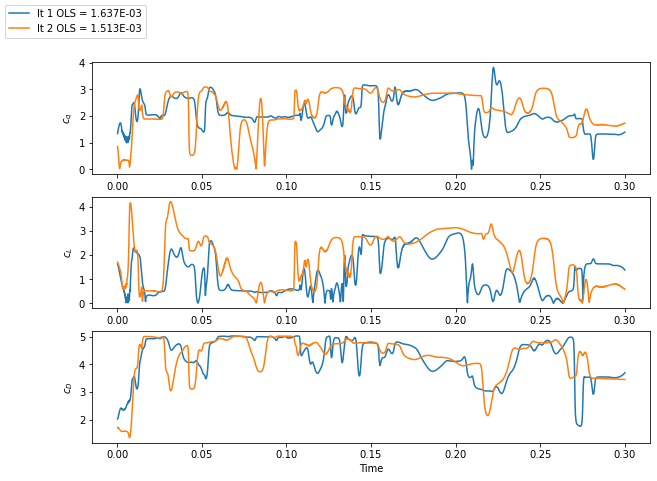

In [35]:
def plot_const(model_data,idx):    
    _, _, error, err_labels, _, consts  = model_data

    fig,ax = plt.subplots(3,1, figsize = (10,7))
    for j in idx:
        const = consts[j]
        label = err_labels[j] + f" OLS = {np.mean(error[j]):.3E}"
        for i in range(len(ax)):
            ax[i].plot(t[1:],const[1:,i], label = label)
            #ax[i].legend()
    ax[-1].set_xlabel("Time")
    ax[0].set_ylabel("$c_q$")
    ax[1].set_ylabel("$c_L$")
    ax[2].set_ylabel("$c_D$")
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')

#plot_const(sigmoid_data_lookahead, [0,1.2])
plot_const(tanh_data_lookahead, [1,2])

# Profiling

In [3]:
from cProfile import run

import numpy as np
import nm_lib as nm
from lossfunc_CFD import *
from sklearn.model_selection import train_test_split
from costfunc import *
from fitting_routines import iterate_fit_simple, setup_evolve_predict, setup_evolve_CFD_fast
from schedulers import *
import matplotlib.pyplot as plt

from ffnn import FFNN, tanh
#warnings.filterwarnings('ignore')

nump = 256
cfl_cut = 0.1
Nt = 1500 #1500
dt = 0.0002#0.0002
gamma = 5/3
t = np.linspace(0,Nt*dt,Nt+1)

model_lookahead = 1

xx,u,rho,Pg = nm.init_sod_test(nump,1.0,0.125,1.0/gamma,0.125/gamma)
values = nm.ana_sod_shock(xx,gamma,t, Pg[0],Pg[-1],rho[0],rho[-1])
ut,rhot,Pt,et = values[1:]
X = values_to_X(values)
X,y, y_onestep = XY_from_X(X, Nt = model_lookahead)

X_train, X_test, t_train, t_test = train_test_split(X, y)
input_nodes = X_train.shape[1]
output_nodes = 3
epochs = 10

linear_regression = FFNN((input_nodes,

                            int(input_nodes/4),
                            int(input_nodes/12),
 
                            output_nodes*10,

                            output_nodes*3,
                            output_nodes), cost_func=CostOLS, hidden_func = tanh,seed=2023)
linear_regression.set_CFD_params(xx,dt,gamma, Nt=model_lookahead)
linear_regression.setup_evolve_predict(values,t)




#linear_regression.reset_weights() # reset weights such that previous runs or reruns don't affect the weights

#scheduler = Adam(eta=1e-2,rho=1e-2, rho2 = 1e-2)
#scheduler = Constant(eta=1e-2)
scheduler = Momentum(eta=1e-2, momentum=0.5)
#scheduler = Momentum(eta=1e-2, momentum=0.5)
#scores = linear_regression.fit(X_train, t_train, scheduler, epochs=100)
#cProfile.run("linear_regression.fit(X_train, t_train, scheduler, epochs=100)")
evolve_predict = setup_evolve_predict(xx,rhot[0],ut[0],et[0],Pt[0],t,dt,gamma)
evolve_fast = setup_evolve_CFD_fast(xx,rhot[0],ut[0],et[0],Pt[0],t,dt,gamma)
iter_fit = 1
run("iterate_fit_simple(linear_regression,scheduler,evolve_predict,iter_fit,X,y, model_lookahead, eta = 2e-2, epochs=epochs)")


no slice
Momentum: Eta=0.02, Lambda=1e-05
  [=======================================>] 100.0% | train_error: 0.00182 
Mean error =  0.0018017239117047261
         2718647 function calls (2610563 primitive calls) in 3.841 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    15000    0.005    0.000    0.230    0.000 <__array_function__ internals>:177(array_split)
    30200    0.014    0.000    0.059    0.000 <__array_function__ internals>:177(atleast_1d)
      100    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(atleast_2d)
    15150    0.008    0.000    0.085    0.000 <__array_function__ internals>:177(concatenate)
    15152    0.013    0.000    0.066    0.000 <__array_function__ internals>:177(copyto)
      140    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(iscomplexobj)
    45001    0.015    0.000    0.298    0.000 <__array_function__ internals>:177(mean)
       60    0.000    0